In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import ta as ta

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Data Wrangling

In [127]:
def get_data():
    """
    Downloads and wrangles data for BlackSwan 2.0 VIX modeling. 
  
    Combines the two index datasets and creates a 
    new DataFrame (df) that contains the target feature (Trading Days with 3 
    STDV shifts based on a rolling window)
  
    :input: vix  => CBOE VIX Historical Data
    :input: gspc => GSPC S&P 500 index with matching start date to VIX
  
    :return: df  => cominbation VIX/GSPC Dataset with Target Classifier 
    """
  
    ############### Getting Data ##################
  
    vix = (data.DataReader('^VIX', 
                           "yahoo", 
                           start='1990-1-02', 
                           end='2019-6-17')
           .drop(columns = ['Volume', 'Adj Close']))
  
    gspc = data.DataReader('^GSPC', 
                           "yahoo", 
                           start='1990-1-02',
                           end='2019-6-17')
    
    treasury = (pd.read_csv('USTREASURY-YIELD.csv')
                .sort_values(by = 'Date')
                .drop(columns=['1 MO', '2 MO', '20 YR']))
  
    ############### Wrangling Data #################
    
    # Rename the Columns
    vix.columns      = ['vix_high', 'vix_low', 'vix_open', 'vix_close']
    gspc.columns     = ['gspc_high', 'gspc_low', 'gspc_open',
                        'gspc_close','gspc_volume','gspc_adj_close']
  
    # Join the VIX and GSPC
    df = vix.join(gspc)
  
    # Pull Date columns out of the index
    df = df.reset_index()
    
    # Merge DF with the Treasury Data on the Date Feature
    # Date needs to be converted to Datetime format to match df['Date']
    treasury['Date'] = pd.to_datetime(treasury['Date'],
                                      infer_datetime_format=True)
    
    df = pd.merge(df, treasury, how='inner', on='Date')
    
    # Datetime Conversion
    # df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format= True)
  
    ############### Momemntum Feature Engineering ################
  
    # Awesome Oscillator
    df['mom_ao']=ta.momentum.ao(df['gspc_high'],
                                df['gspc_low'],
                                s=5,len=34,
                                fillna=True)

    # Money Flow Index
    df['mom_mf']=ta.momentum.money_flow_index(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              df['gspc_volume'],
                                              n=14,fillna=True)
  
    # Relative Strength Index
    df['mom_rsi'] = ta.momentum.rsi(df['gspc_close'],
                                    n=14,
                                    fillna=True)
  
    # Stochasitc Oscillator
    df['mom_stoch']=ta.momentum.stoch(df['gspc_high'],
                                      df['gspc_low'],
                                      df['gspc_close'],
                                      n=14,
                                      fillna=True)
  
    # Stochasitc Signal
    df['mom_st_sig']=ta.momentum.stoch_signal(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              n=14,
                                              d_n=3,
                                              fillna=True)
  
    # True Strength Indicator
    df['mom_tsi'] = ta.momentum.tsi(df['gspc_close'],
                                    r=25,
                                    s=13,
                                    fillna=True)
  
    # Ultimate Oscillator
    df['mom_uo'] = ta.momentum.uo(df['gspc_high'],
                                  df['gspc_low'],
                                  df['gspc_close'], 
                                  s=7, 
                                  m=14, 
                                  len=28, 
                                  ws=4.0, 
                                  wm=2.0, 
                                  wl=1.0,
                                  fillna=True)
  
    # Williams %R
    df['mom_wr']=ta.momentum.wr(df['gspc_high'],
                                df['gspc_low'],
                                df['gspc_close'],
                                lbp=14,fillna=True)
  
    ############### Volume Feature Engineering ####################
  
    # Accumulation/Distribution Index
    df['vol_adi']=ta.volume.acc_dist_index(df['gspc_high'],
                                           df['gspc_low'],
                                           df['gspc_close'],
                                           df['gspc_volume'],
                                           fillna=True)
  
    # Chaikin Money Flow
    df['vol_cmf'] = ta.volume.chaikin_money_flow(df['gspc_high'],
                                                 df['gspc_low'],
                                                 df['gspc_close'],
                                                 df['gspc_volume'],
                                                 n=20,fillna=True)
  
    # Ease of Movement
    df['vol_eom'] = ta.volume.ease_of_movement(df['gspc_high'],
                                               df['gspc_low'],
                                               df['gspc_close'],
                                               df['gspc_volume'],
                                               n=20,fillna=True)
  
    # Force Index
    df['vol_fm'] = ta.volume.force_index(df['gspc_close'],
                                         df['gspc_volume'],
                                         n=2,fillna=True)
  
    # Negative Volume Index
    df['vol_nvi'] = ta.volume.negative_volume_index(df['gspc_close'],
                                                    df['gspc_volume'],
                                                    fillna=True)
  
    # On-Balance Volume
    df['vol_obv'] = ta.volume.on_balance_volume(df['gspc_close'],
                                                df['gspc_volume'],
                                                fillna=True)
  
    # Volume-Price Trend
    df['vol_vpt'] = ta.volume.volume_price_trend(df['gspc_close'],
                                                 df['gspc_volume'],
                                                 fillna=True)
    
    ############### Volatility Feature Engineering
    
    #Average True Range
    df['atr_low'] = ta.volatility.average_true_range(df['gspc_high'],
                                                     df['gspc_low'],
                                                     df['gspc_close'],
                                                     n=23)
    
    df['atr_high'] = ta.volatility.average_true_range(df['gspc_high'],
                                                      df['gspc_low'],
                                                      df['gspc_close'],
                                                      n=37)
  
    ############### Target Creation #################
  
    # Determine daily market movement between Close and Close
    df['vix_move']  = (1 - df['vix_close']
                       .shift(1)/df['vix_close'])
  
    df['gspc_move'] = (1 - df['gspc_close']
                       .shift(1)/df['gspc_close'])
  
  
  
    ##### 30 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_30'] = (df['vix_move']
                            .rolling(30).std())
  
    df['gspc_rolling_30'] = (df['gspc_move']
                             .rolling(30).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_30'] = np.where(abs(df['gspc_move'])
                                 >=3*df['gspc_rolling_30'],1,0)
  
    df['2.5sd_move_30'] = np.where(abs(df['gspc_move'])
                                   >=2.5*df['gspc_rolling_30'],1,0)
  
    df['2sd_move_30'] = np.where(abs(df['gspc_move'])
                                 >=2*df['gspc_rolling_30'],1,0)
  
    df['1.5sd_move_30'] = np.where(abs(df['gspc_move'])
                                   >=1.5*df['gspc_rolling_30'],1,0)
  
  
    ##### 90 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_90'] = (df['vix_move']
                            .rolling(90).std())
  
    df['gspc_rolling_90'] = (df['gspc_move']
                             .rolling(90).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_90'] = np.where(abs(df['gspc_move'])
                                 >=3*df['gspc_rolling_90'],1,0)
  
    df['2.5sd_move_90'] = np.where(abs(df['gspc_move'])
                                   >=2.5*df['gspc_rolling_90'],1,0)
  
    df['2sd_move_90'] = np.where(abs(df['gspc_move'])
                                 >=2*df['gspc_rolling_90'],1,0)
  
    df['1.5sd_move_90'] = np.where(abs(df['gspc_move'])
                                   >=1.5*df['gspc_rolling_90'],1,0)
  
  
    ##### 120 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_120'] = (df['vix_move']
                            .rolling(120).std())
  
    df['gspc_rolling_120'] = (df['gspc_move']
                             .rolling(120).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_120'] = np.where(abs(df['gspc_move'])
                                  >=3*df['gspc_rolling_120'],1,0)
  
    df['2.5sd_move_120'] = np.where(abs(df['gspc_move'])
                                    >=2.5*df['gspc_rolling_120'],1,0)
  
    df['2sd_move_120'] = np.where(abs(df['gspc_move'])
                                  >=2*df['gspc_rolling_120'],1,0)
  
    df['1.5sd_move_120'] = np.where(abs(df['gspc_move'])
                                    >=1.5*df['gspc_rolling_120'],1,0)
  
  
    ##### 252 Day Rolling Average
  
    # Find the Standard Deviation based on a rolling average (year)
    df['vix_rolling_252'] = (df['vix_move']
                            .rolling(252).std())
  
    df['gspc_rolling_252'] = (df['gspc_move']
                             .rolling(252).std())
  
    # Create new target features based on Different STDEV thresholds
    df['3sd_move_252'] = np.where(abs(df['gspc_move'])
                                  >=3*df['gspc_rolling_252'],1,0)
  
    df['2.5sd_move_252'] = np.where(abs(df['gspc_move'])
                                    >=2.5*df['gspc_rolling_252'],1,0)
  
    df['2sd_move_252'] = np.where(abs(df['gspc_move'])
                                  >=2*df['gspc_rolling_252'],1,0)
  
    df['1.5sd_move_252'] = np.where(abs(df['gspc_move'])
                                    >=1.5*df['gspc_rolling_252'],1,0)
  
  
    ############## Handling Null Values ##################
    
    # Interpolating the Null Values for 30yr Treasury Bonds
    df['30 YR'] = (df['30 YR'].interpolate(method='spline',
                                           order=4))
    
    # Drop the rest
    df = df.dropna()
  
    return df
  

In [128]:
df = get_data()

In [47]:
def crash_dates():

    start_date = '2008-09-10'
    end_date = '2009-03-05'
    crash = (df[df['Date'] > start_date])
    crash = (crash[crash['Date'] < end_date])
  
    return crash

In [48]:
#Dates of 3 STDEV movements
sd_3_dates = df[df['3sd_move_30'] == 1]['Date']

In [129]:
print(df.shape,'\n', df.isnull().sum(),'\n',
      df.info(),'\n', df.describe(),'\n\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7106 entries, 252 to 7360
Data columns (total 63 columns):
Date                7106 non-null datetime64[ns]
vix_high            7106 non-null float64
vix_low             7106 non-null float64
vix_open            7106 non-null float64
vix_close           7106 non-null float64
gspc_high           7106 non-null float64
gspc_low            7106 non-null float64
gspc_open           7106 non-null float64
gspc_close          7106 non-null float64
gspc_volume         7106 non-null int64
gspc_adj_close      7106 non-null float64
3 MO                7106 non-null float64
6 MO                7106 non-null float64
1 YR                7106 non-null float64
2 YR                7106 non-null float64
3 YR                7106 non-null float64
5 YR                7106 non-null float64
7 YR                7106 non-null float64
10 YR               7106 non-null float64
30 YR               7106 non-null float64
mom_ao              7106 non-null float64
mom_

,Date,vix_high,vix_low,vix_open,vix_close,gspc_high,gspc_low,gspc_open,gspc_close,gspc_volume,gspc_adj_close,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,30 YR,mom_ao,mom_mf,mom_rsi,mom_stoch,mom_st_sig,mom_tsi,mom_uo,mom_wr,vol_adi,vol_cmf,vol_eom,vol_fm,vol_nvi,vol_obv,vol_vpt,atr_low,atr_high,vix_move,gspc_move,vix_rolling_30,gspc_rolling_30,3sd_move_30,2.5sd_move_30,2sd_move_30,1.5sd_move_30,vix_rolling_90,gspc_rolling_90,3sd_move_90,2.5sd_move_90,2sd_move_90,1.5sd_move_90,vix_rolling_120,gspc_rolling_120,3sd_move_120,2.5sd_move_120,2sd_move_120,1.5sd_move_120,vix_rolling_252,gspc_rolling_252,3sd_move_252,2.5sd_move_252,2sd_move_252,1.5sd_move_252
252,1991-01-04,27.190001,27.190001,27.190001,27.190001,322.350006,318.869995,321.910004,321.000000,140820000,321.000000,6.73,6.82,6.83,7.17,7.37,7.65,7.94,8.02,8.20,1.730324,47.151724,28.796672,15.661794,13.533556,7.840492,42.658298,-84.338206,-1.092754e+08,0.073116,-1.429087e-08,-7.924318e+07,802.515923,2.261140e+09,-2.365257e+06,3.747999,4.115944,-0.027216,-0.002835,0.046174,0.007249,0,0,0,0,0.048068,0.011178,0,0,0,0,0.073464,0.011574,0,0,0,0,0.070553,0.009940,0,0,0,0
253,1991-01-07,28.950001,28.950001,28.950001,28.950001,320.970001,315.440002,320.970001,315.440002,130610000,315.440002,6.71,6.84,6.84,7.20,7.43,7.75,8.04,8.13,8.32,-0.222910,47.759075,20.293223,0.000000,5.252164,6.516885,35.161492,-100.000000,-9.904705e+07,0.098190,-2.308569e-08,7.013481e+07,788.615653,2.130530e+09,-2.660361e+06,3.826782,4.154973,0.060794,-0.017626,0.046620,0.007963,0,0,1,1,0.047960,0.011240,0,0,0,1,0.073666,0.011657,0,0,0,1,0.070580,0.009997,0,0,0,1
254,1991-01-08,30.379999,30.379999,30.379999,30.379999,316.970001,313.790009,315.440002,314.899994,143390000,314.899994,6.64,6.74,6.75,7.15,7.39,7.74,8.06,8.16,8.37,-2.875352,47.255924,19.643185,5.942108,7.201301,5.262130,36.594105,-94.057892,-1.738986e+08,0.089016,-2.323096e-08,-1.567702e+07,788.615653,1.987140e+09,-2.507751e+06,3.798661,4.128622,0.047070,-0.001715,0.047027,0.007951,0,0,0,0,0.045785,0.010750,0,0,0,0,0.073756,0.011645,0,0,0,0,0.070561,0.009985,0,0,0,0
255,1991-01-09,33.299999,33.299999,33.299999,33.299999,320.730011,310.929993,314.899994,311.489990,191100000,311.489990,6.44,6.61,6.68,7.10,7.46,7.81,8.12,8.25,8.46,-5.357588,37.837654,15.926122,2.599802,2.847303,3.742935,26.979367,-97.400198,-2.125488e+08,-0.017458,-2.174151e-08,-2.389362e+08,788.615653,1.796040e+09,-2.314865e+06,4.059589,4.281903,0.087688,-0.010947,0.047522,0.008145,0,0,0,0,0.046686,0.010809,0,0,0,0,0.074165,0.011675,0,0,0,0,0.070725,0.009989,0,0,0,0
256,1991-01-10,31.330000,31.330000,31.330000,31.330000,314.769989,311.510010,311.510010,314.529999,124510000,314.529999,6.40,6.57,6.64,7.14,7.39,7.76,8.02,8.16,8.37,-7.449499,35.733921,29.624715,16.713114,8.418341,2.694182,28.449555,-83.286886,-6.308227e+07,0.045918,-2.493523e-08,6.985508e+06,796.312203,1.920550e+09,-8.542284e+05,4.025694,4.254825,-0.062879,0.009665,0.049420,0.008298,0,0,0,0,0.046676,0.010817,0,0,0,0,0.073634,0.011698,0,0,0,0,0.070832,0.010005,0,0,0,0


## Target and Features

In [12]:
targets  = ['1.5sd_move_30','2sd_move_30','2.5sd_move_30','3sd_move_30',
            '1.5sd_move_90','2sd_move_90','2.5sd_move_90','3sd_move_90',
            '1.5sd_move_120','2sd_move_120','2.5sd_move_120','3sd_move_120',
            '1.5sd_move_252','2sd_move_252','2.5sd_move_252','3sd_move_252']

leakage  = ['Date']

features  = (df.drop(columns = targets)
            .drop(columns = leakage)
            .columns)

## Baseline Modeling

In [13]:
# Baseline Modeling Imports

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

In [14]:
def split(target, features=features):
    """
    Temporal Train Test Split. Holdout is most recent data.  
    """
    
    X = df[features]
    y = df[target]
    
    X_train = X[:int(len(X.index)*.7)]
    X_test= X[int(len(X.index)*.7):len(X.index)]
    y_train=y[:int(len(y.index)*.7)]
    y_test=y[int(len(y.index)*.7):len(y.index)]
    
    return X_train, X_test, y_train, y_test
    

In [15]:
def log_reg(target):
  
  X_train, X_test, y_train, y_test = split(target)
  
  
  LR=LogisticRegression(solver='lbfgs')
  LR.fit(X_train,y_train)
               
  #Predict the y test 
  
  y_pred_LR=LR.predict(X_test)   
               
               #Print the accuracy score of our predicted y using metrics from sklearn
  
  score = metrics.accuracy_score(y_test, y_pred_LR)
  
  return score

In [16]:
def gauss(target):
  
    X_train, X_test, y_train, y_test = split(target)

    GNB = GaussianNB()
    GNB.fit(X_train,y_train)
               #Predict the y test
    y_pred=GNB.predict(X_test)
               #Print the accuracy score of our predicted y using metrics from sklearn
    
    return 

In [17]:
def check_models():
  
    print('Baseline Probability')
    for target in targets:
      print(target+':', df[target].value_counts(normalize=True)[0],'\n')
    print('\n\n Logisitic Regression:\n')
    for target in targets:
      print(target+":", log_reg(target),'\n')
    print('\n\n Gaussian Naive Bayes:\n')
    for target in targets: 
      print(target+":", gauss(target),'\n')

In [18]:
def results(y_test, y_pred):

    print(' Accuracy: ', accuracy_score(y_test, y_pred),'\n',
          'Precision: ', precision_score(y_test, y_pred), '\n',
          '   Recall: ', recall_score(y_test, y_pred), '\n',
          '  ROC_AUC: ', roc_auc_score(y_test, y_pred), '\n\n')
        
    return pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns = ['predicted_0', 'predicted_1'],
                        index = ['actaul_0', 'actual_1'])

In [21]:
  
X_train, X_test, y_train, y_test = split('3sd_move_30')

GNB = GaussianNB()
GNB.fit(X_train,y_train)
               #Predict the y test
y_pred=GNB.predict(X_test)

In [22]:
results(y_test, y_pred)

 Accuracy:  0.9688806316767301 
 Precision:  0.11864406779661017 
    Recall:  0.3181818181818182 
   ROC_AUC:  0.646890064417047 




,predicted_0,predicted_1
actaul_0,2079,52
actual_1,15,7


0

In [87]:
vix = (data.DataReader('^VIX', 
                       "yahoo", 
                       start='1990-1-02', 
                       end='2019-6-17')
       .drop(columns = ['Volume', 'Adj Close'])
       .reset_index())

In [96]:
treasury['Date'] = pd.to_datetime(treasury['Date'])

In [104]:
pd.merge(treasury,vix,how='inner',on='Date')

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,High,Low,Open,Close
0,1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00,17.240000,17.240000,17.240000,17.240000
1,1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04,18.190001,18.190001,18.190001,18.190001
2,1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04,19.219999,19.219999,19.219999,19.219999
3,1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06,20.110001,20.110001,20.110001,20.110001
4,1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09,20.260000,20.260000,20.260000,20.260000
5,1990-01-09,NaN,NaN,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,NaN,8.10,22.200001,22.200001,22.200001,22.200001
6,1990-01-10,NaN,NaN,7.75,7.78,7.77,7.91,7.95,7.92,8.00,8.03,NaN,8.11,22.440001,22.440001,22.440001,22.440001
7,1990-01-11,NaN,NaN,7.80,7.80,7.77,7.91,7.95,7.94,8.01,8.04,NaN,8.11,20.049999,20.049999,20.049999,20.049999
8,1990-01-12,NaN,NaN,7.74,7.81,7.76,7.93,7.98,7.99,8.07,8.10,NaN,8.17,24.639999,24.639999,24.639999,24.639999
9,1990-01-16,NaN,NaN,7.89,7.99,7.92,8.10,8.13,8.11,8.18,8.20,NaN,8.25,24.180000,24.180000,24.180000,24.180000


In [105]:
df = pd.merge(treasury, vix, left_on='Date', right_on='Date')

In [99]:
df.shape

(7361, 17)

In [55]:
(data.DataReader('^VIX', "yahoo", 
                 start='1990-1-02', end='2019-6-17').
 drop(columns = ['Volume', 'Adj Close'])).shape

(7423, 4)

## ARIMA Modeling

In [ ]:
#ARIMA Modeling Imports

from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

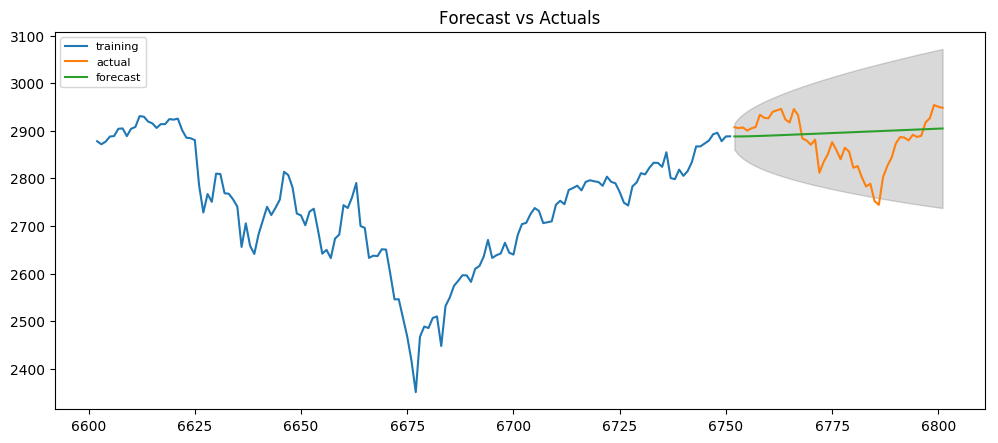

In [ ]:

train = df.gspc_close[1:-50]
test = df.gspc_close[-50:]
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(50, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-150:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()